In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import metrics
import os
from pathlib import Path
BASE_DIR = Path('.').resolve().parent.parent.parent
os.chdir(BASE_DIR)
from phm08ds.models import experiment

## Load Dataset

In [2]:
folderpath = os.path.abspath(os.getcwd()) + '/phm08ds/data/files/'
data_op_1 = pd.read_csv(folderpath + 'data_op_01.csv')
data_op_1.head()

,unit,time_step,operational_setting_1,operational_setting_2,operational_setting_3,Sensor_0,Sensor_1,Sensor_2,Sensor_3,Sensor_4,...,Sensor_13,Sensor_14,Sensor_15,Sensor_16,Sensor_17,Sensor_18,Sensor_19,Sensor_20,Health_state,Operational_condition
0,1,1,10.0047,0.2501,20.0,489.05,604.13,1499.45,1309.95,10.52,...,8120.83,8.6216,0.03,368,2319,100.0,28.58,17.1735,1,1
14,1,15,9.9988,0.2500,20.0,489.05,604.63,1497.87,1302.51,10.52,...,8124.37,8.6496,0.03,369,2319,100.0,28.84,17.0805,1,1
15,1,16,9.9987,0.2500,20.0,489.05,604.61,1500.47,1311.39,10.52,...,8127.07,8.6609,0.03,369,2319,100.0,28.71,17.1759,1,1
17,1,18,10.0066,0.2507,20.0,489.05,604.23,1502.57,1304.56,10.52,...,8119.39,8.6646,0.03,367,2319,100.0,28.60,17.1096,1,1
35,1,36,10.0024,0.2504,20.0,489.05,604.43,1499.85,1306.89,10.52,...,8121.73,8.6260,0.03,369,2319,100.0,28.52,17.1036,2,1


## Data preprocessing

### Get rid of informations there are not sensor readings

Wang (2008) reports Sensor 15 has importat information. However, there are no relevant informations of this sensor. The data seems to be corrupted like this:

<AxesSubplot: xlabel='time_step'>

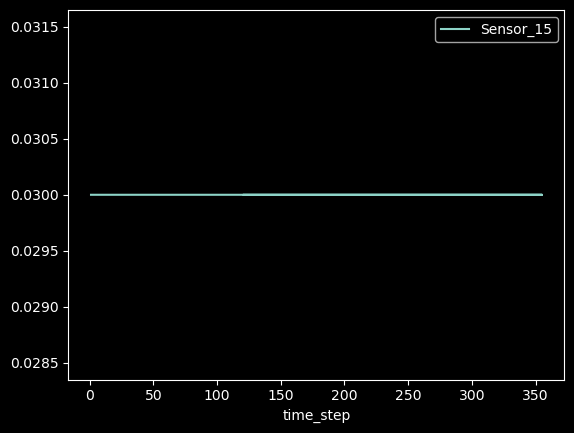

In [3]:
data_op_1.plot(x='time_step', y='Sensor_15')

Let's remove it from our database creating an object transformer.

In [4]:
from phm08ds.features.feature_selection import RemoveSensor

tf_remove_sensor_15 = RemoveSensor(sensors=[15])
data_op_1 = tf_remove_sensor_15.fit_transform(data_op_1)
data_op_1.head()

,unit,time_step,operational_setting_1,operational_setting_2,operational_setting_3,Sensor_0,Sensor_1,Sensor_2,Sensor_3,Sensor_4,...,Sensor_12,Sensor_13,Sensor_14,Sensor_16,Sensor_17,Sensor_18,Sensor_19,Sensor_20,Health_state,Operational_condition
0,1,1,10.0047,0.2501,20.0,489.05,604.13,1499.45,1309.95,10.52,...,2388.13,8120.83,8.6216,368,2319,100.0,28.58,17.1735,1,1
14,1,15,9.9988,0.2500,20.0,489.05,604.63,1497.87,1302.51,10.52,...,2388.12,8124.37,8.6496,369,2319,100.0,28.84,17.0805,1,1
15,1,16,9.9987,0.2500,20.0,489.05,604.61,1500.47,1311.39,10.52,...,2388.08,8127.07,8.6609,369,2319,100.0,28.71,17.1759,1,1
17,1,18,10.0066,0.2507,20.0,489.05,604.23,1502.57,1304.56,10.52,...,2388.06,8119.39,8.6646,367,2319,100.0,28.60,17.1096,1,1
35,1,36,10.0024,0.2504,20.0,489.05,604.43,1499.85,1306.89,10.52,...,2388.11,8121.73,8.6260,369,2319,100.0,28.52,17.1036,2,1


Before feeding to the classifier, let's remove unwanted information, such as unit, time_step and operational settings.

In [5]:
from phm08ds.features.feature_selection import RemoveInfo

tf_remove_info = RemoveInfo()

data_with_features = tf_remove_info.fit_transform(data_op_1)
data_with_features.head()

,Sensor_0,Sensor_1,Sensor_2,Sensor_3,Sensor_4,Sensor_5,Sensor_6,Sensor_7,Sensor_8,Sensor_9,...,Sensor_11,Sensor_12,Sensor_13,Sensor_14,Sensor_16,Sensor_17,Sensor_18,Sensor_19,Sensor_20,Health_state
0,489.05,604.13,1499.45,1309.95,10.52,15.49,394.88,2318.87,8770.20,1.26,...,372.15,2388.13,8120.83,8.6216,368,2319,100.0,28.58,17.1735,1
14,489.05,604.63,1497.87,1302.51,10.52,15.50,394.93,2318.90,8771.08,1.26,...,371.84,2388.12,8124.37,8.6496,369,2319,100.0,28.84,17.0805,1
15,489.05,604.61,1500.47,1311.39,10.52,15.49,394.44,2318.87,8775.86,1.26,...,372.19,2388.08,8127.07,8.6609,369,2319,100.0,28.71,17.1759,1
17,489.05,604.23,1502.57,1304.56,10.52,15.49,394.31,2318.93,8778.55,1.26,...,372.03,2388.06,8119.39,8.6646,367,2319,100.0,28.60,17.1096,1
35,489.05,604.43,1499.85,1306.89,10.52,15.49,394.36,2318.94,8771.15,1.26,...,371.77,2388.11,8121.73,8.6260,369,2319,100.0,28.52,17.1036,2


We need to normalize our data. Let's use Z-score standardization.

In [6]:
from sklearn.preprocessing import StandardScaler

tf_std_scaller = StandardScaler()
data_with_features_std = tf_std_scaller.fit_transform(data_with_features.drop(labels='Health_state', axis=1))
data_with_features_std

array([[-5.68434189e-14, -1.66575294e+00, -4.60782655e-01, ...,
         0.00000000e+00,  3.77665056e-01,  6.75931281e-01],
       [-5.68434189e-14, -6.08240322e-01, -7.32647265e-01, ...,
         0.00000000e+00,  2.17941314e+00, -4.02161432e-01],
       [-5.68434189e-14, -6.50540827e-01, -2.85275123e-01, ...,
         0.00000000e+00,  1.27853910e+00,  7.03753028e-01],
       ...,
       [-5.68434189e-14,  1.76058794e+00,  1.38376710e+00, ...,
         0.00000000e+00, -9.38997008e-01, -4.68238082e-01],
       [-5.68434189e-14,  2.18359299e+00,  9.98338792e-01, ...,
         0.00000000e+00, -2.04776506e+00, -1.91265047e+00],
       [-5.68434189e-14,  1.50678491e+00,  4.47726925e-01, ...,
         0.00000000e+00, -4.53910985e-01, -4.68238082e-01]])

In [7]:
labels_op_1 = np.array(data_with_features['Health_state'])
labels_op_1

array([1, 1, 1, ..., 4, 4, 4])

# Classification steps

## Load Experiment model

In [8]:
from phm08ds.models import experiment

## Define classifiers and its specifications

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier

In [10]:
knn_clf = KNeighborsClassifier()
random_forest_clf = RandomForestClassifier()
naive_bayes_clf = GaussianNB()
gaussian_linear_clf = LinearDiscriminantAnalysis()
gaussian_quadratic_clf = QuadraticDiscriminantAnalysis()
perceptron_clf = Perceptron()
sgd_clf = SGDClassifier()

In [13]:
knn_clf

KNeighborsClassifier()

In [14]:
random_forest_clf

RandomForestClassifier()

In [15]:
perceptron_clf

Perceptron()

In [16]:
sgd_clf

SGDClassifier()

## Put all clf in a dictionary:

In [18]:
classifiers = {'KNN': knn_clf, 'RF': random_forest_clf, 'Naive_bayes': naive_bayes_clf,
               'Gaussian_linear': gaussian_linear_clf, 'Gaussian_quadratic': gaussian_quadratic_clf,
               'Perceptron': perceptron_clf, 'SGDClassifier': sgd_clf}

## Train Classifiers and test them

Stratified cross-validation for model selection are going to be used.

In [19]:
kfolds = 10
clf_outputs = experiment.run_classifiers(data_with_features_std, labels_op_1, classifiers, kfolds)

/Users/tomxu/miniforge3/envs/ml/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/tomxu/miniforge3/envs/ml/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:912: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/Users/tomxu/miniforge3/envs/ml/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:912: RuntimeWarning: invalid value encountered in multiply
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/Users/tomxu/miniforge3/envs/ml/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:915: RuntimeWarning: divide by zero encountered in log
  u = np.asarray([np.sum(np.log(s)) for s in self.scalings_])
/Users/tomxu/miniforge3/envs/ml/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:912: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/Users/tomxu/miniforge3/envs/ml/lib/python3.9/sit

## Performance assessment

Saving variables in a dictionary:

In [20]:
results = {}
results['train'] = experiment.results_clf(4, clf_outputs['train']['true'], clf_outputs['train']['pred'])
results['test'] = experiment.results_clf(4, clf_outputs['test']['true'], clf_outputs['test']['pred'])

/Users/tomxu/miniforge3/envs/ml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tomxu/miniforge3/envs/ml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tomxu/miniforge3/envs/ml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tomxu/miniforge3/envs/ml/lib/python3

## Savel results, models and pipeline to a .pkl file 

In [14]:
from sklearn.pipeline import Pipeline

data_preprocessing = Pipeline([('remove_sensor_15', tf_remove_sensor_15),
                               ('remove_info', tf_remove_info),
                               ('std_scaler', tf_std_scaller)
                              ])

In [15]:
experiment.save_models(classifiers)
experiment.save_pipeline(data_preprocessing)

## Save results to CSVs and figures

In [16]:
experiment.export_results(results['test'], 'test')
experiment.export_results(results['train'], 'train')

/mnt/Work/Mestrado/Mestrado/MP-Safety_ITA/Analyses_and_Experiments/PHM08_data_science/notebooks/E01_PHM08-train_CLF/model_selection-OP_01-navarmn
KNN
RF
Naive_bayes
Gaussian_linear
Gaussian_quadratic
Perceptron
SGDClassifier
/mnt/Work/Mestrado/Mestrado/MP-Safety_ITA/Analyses_and_Experiments/PHM08_data_science/notebooks/E01_PHM08-train_CLF/model_selection-OP_01-navarmn
KNN
RF
Naive_bayes
Gaussian_linear
Gaussian_quadratic
Perceptron
SGDClassifier
